**Imports**

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
files = os.listdir('./data')
datasets = []
features = ['Close', 'Open', 'Low', 'High', 'Volume']
total_len = 0
scaler = MinMaxScaler()

for i in range(len(files)):
    df = pd.read_csv(f'./data/{files[i]}')
    df = df[features]
    dataset = scaler.fit_transform(df[features])
    datasets.append(dataset)
    total_len += len(df)
    print(f'{files[i][:-4]} dataframe length: {len(df)}')
    
print(f'\nTotal length: {total_len}')

ADA-USD dataframe length: 2063
BTC-USD dataframe length: 3212
DOGE-USD dataframe length: 2063
ETH-USD dataframe length: 2063
LTC-USD dataframe length: 3212
SOL-USD dataframe length: 1180
XMR-USD dataframe length: 2063
XRP-USD dataframe length: 2063

Total length: 17919


In [3]:
def create_sequences(data, seq_length=60, space=20):
    X = []
    y = []
    for i in range(len(data) - (seq_length + space)):
        seq = data[i:i+seq_length]
        target = data[i+seq_length+space][0]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

In [4]:
class CryptoDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [6]:
ensemble_models = []

for i in range(len(datasets)):
    X, y = create_sequences(datasets[i])
    
    torch.manual_seed(1)
    
    batch_size = 8
    train_dataset = CryptoDataset(X, y)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    input_size = len(features)
    hidden_size = 32
    output_size = 1
    model = LSTM(input_size, hidden_size, output_size)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100

    print(f'Dataset number {i+1}:')
    
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_dataloader:        
            output = model(batch_X)
            output = output.view(-1)
            loss = loss_fn(output, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    
    ensemble_models.append(model)

Dataset number 1:
Epoch [10/100], Loss: 0.001318
Epoch [20/100], Loss: 0.001535
Epoch [30/100], Loss: 0.000499
Epoch [40/100], Loss: 0.000870
Epoch [50/100], Loss: 0.001971
Epoch [60/100], Loss: 0.004338
Epoch [70/100], Loss: 0.001493
Epoch [80/100], Loss: 0.001572
Epoch [90/100], Loss: 0.002082
Epoch [100/100], Loss: 0.002828
Dataset number 2:
Epoch [10/100], Loss: 0.006971
Epoch [20/100], Loss: 0.001910
Epoch [30/100], Loss: 0.004566
Epoch [40/100], Loss: 0.006932
Epoch [50/100], Loss: 0.002847
Epoch [60/100], Loss: 0.005669
Epoch [70/100], Loss: 0.000311
Epoch [80/100], Loss: 0.001359
Epoch [90/100], Loss: 0.000682
Epoch [100/100], Loss: 0.004787
Dataset number 3:
Epoch [10/100], Loss: 0.000998
Epoch [20/100], Loss: 0.004367
Epoch [30/100], Loss: 0.000354
Epoch [40/100], Loss: 0.000433
Epoch [50/100], Loss: 0.000330
Epoch [60/100], Loss: 0.000989
Epoch [70/100], Loss: 0.017681
Epoch [80/100], Loss: 0.000952
Epoch [90/100], Loss: 0.001024
Epoch [100/100], Loss: 0.000361
Dataset numbe

In [7]:
def ensemble_predict(inputs):
    predictions = []
    for model in ensemble_models:
        model.eval()  
        with torch.no_grad():
            X_test_eval = torch.from_numpy(inputs).float()
            y_pred = model(X_test_eval)
            predictions.append(y_pred.detach().numpy())

    ensemble_predictions = torch.mean(torch.tensor(np.array(predictions)), dim=0)
    return ensemble_predictions

## Testing

In [10]:
files = os.listdir('./data_test')
dates = []
coin_names = []
test_datasets = []

for i in range(len(files)):
    df = pd.read_csv(f'./data_test/{files[i]}')
    if i == 0:
        dates = df['Date'][:286]
    df = df[features]
    dataset = scaler.fit_transform(df[features])
    coin_names.append(files[i][:-4])
    test_datasets.append(dataset)

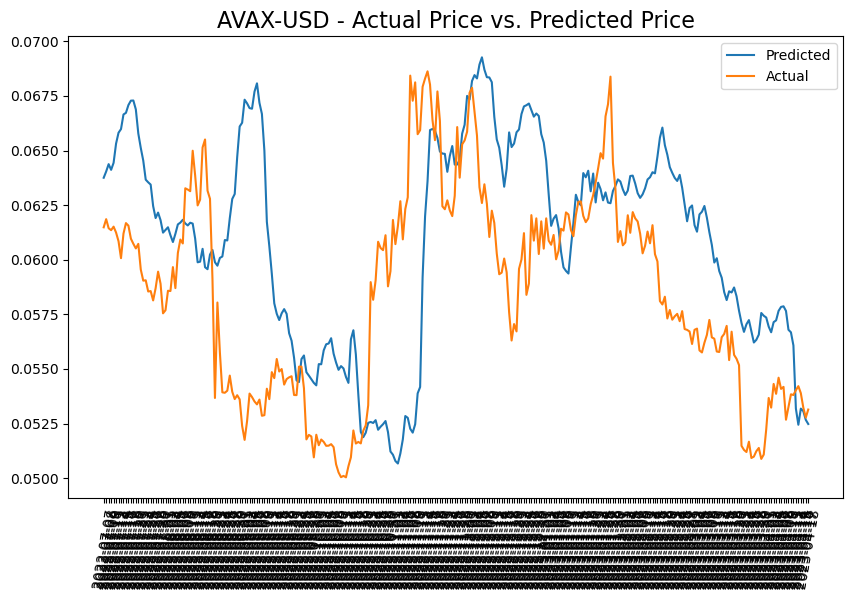

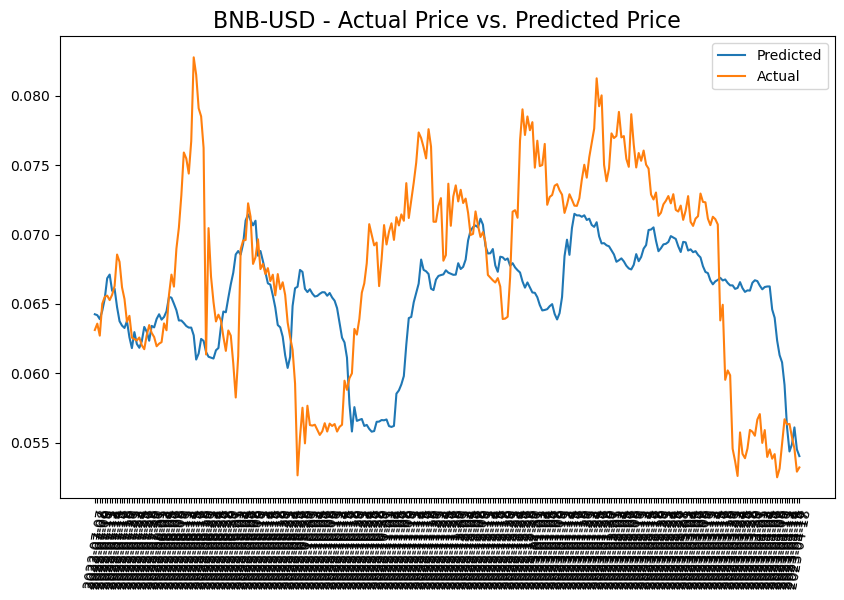

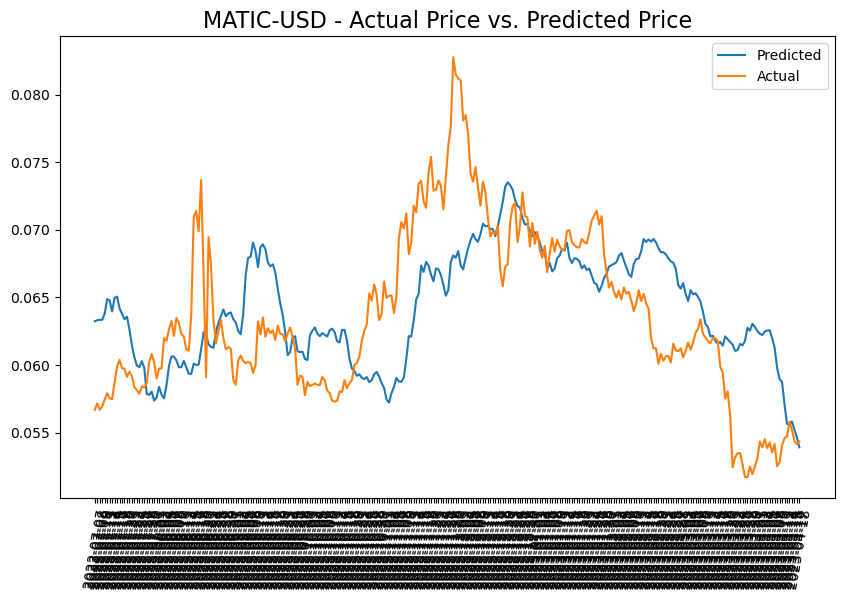

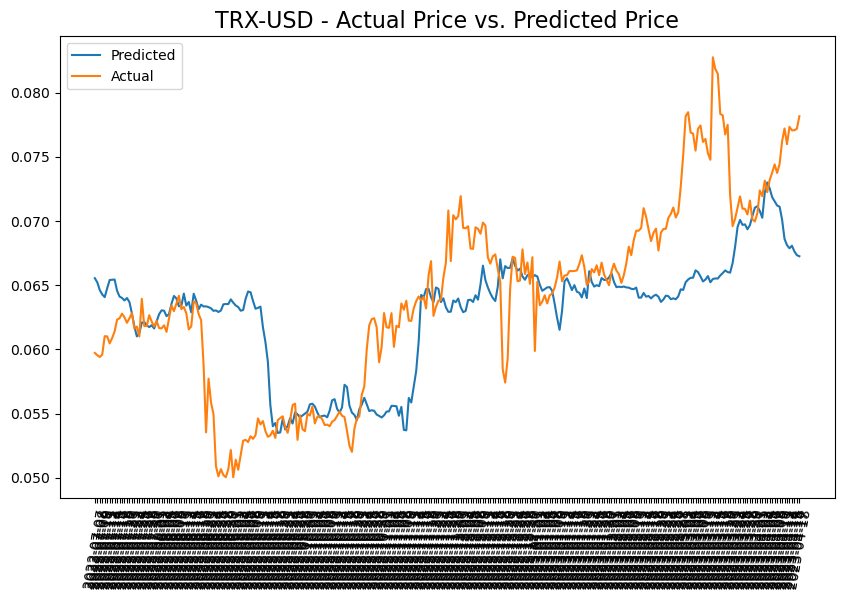

In [11]:
for i, coin_name in enumerate(coin_names):
    X_test, y_test = create_sequences(test_datasets[i])
    
    y_preds = ensemble_predict(X_test)
    y_preds = np.append(y_preds, np.zeros((286, 4), dtype=int), axis=1)
    y_preds = scaler.inverse_transform(y_preds)
    
    y_test = np.expand_dims(y_test, axis=1)
    y_test = np.append(y_test, np.zeros((286, 4), dtype=int), axis=1)
    y_test = scaler.inverse_transform(y_test)
    
    fig, ax = plt.subplots(figsize=(10, 6)) 
    ax.ticklabel_format(style='plain')

    x = dates
    x_list = list(x)

    ax.plot(x, y_preds[:, 0], label="Predicted")
    ax.plot(x, y_test[:, 0], label="Actual")

    ax.set_xticks(list(x))
    ax.set_xticklabels(list(x), rotation=80)

    ax.set_title(f'{coin_name} - Actual Price vs. Predicted Price', fontsize=16)

    ax.legend()

    plt.show()